# Introduction 

Marine microbes account for nearly 90% of all marine biomass [1]. Marine bacteria play a role in influencing the climate, play a crucial role in biogeochemical cycles in the ocean, maintaining the health and resilience of the ecosystem. [2]. 

Despite the crucial role played by Marine bacteria in the Earth's environment, very little is known about factors that influence their population. Despite these gaps, it is agreed that marine bacteria respond to physical conditions (temperature and salinity), available resources (Nutrients and Minerals), and interactions with other organisms like marine diatoms. Given the current climate change crisis, it is crucial to understand how the marine microbial communities are getting impacted [2]. 

In this notebook, we will aim to analyze the Marine Bacterial Abundance over the span of two years. We also try to study the impact of seasonality on marine bacterial abundance, and the factors that play a role in the seasonal variation. We also try to develop two different models to try and predict the logarithm of the bacterial abundance.


In [2]:
# retrieving dataset 
!wget https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/main/assignments/spring22/PIDweekly_env_data.txt

--2022-03-22 21:55:23--  https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/main/assignments/spring22/PIDweekly_env_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12985 (13K) [text/plain]
Saving to: ‘PIDweekly_env_data.txt’

PIDweekly_env_data. 100%[===================>]  12.68K  --.-KB/s    in 0.005s  

2022-03-22 21:55:24 (2.27 MB/s) - ‘PIDweekly_env_data.txt’ saved [12985/12985]



In [2]:
# loading all necessary packages 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import scipy.stats as stats

In [3]:
# loading the dataset 
df = pd.read_csv("PIDweekly_env_data.txt", delim_whitespace=True)
df

,SampleID,YearDay,Bacteria_abundance,Projected_Daily_Insolation,Temp,MLLW,Salinity,Oxygen_Saturation,pH,DIC,Chlorophyll,NH4,NO2.NO3,PO4,SiO4
0,PID126,19,1362561.576,219.38,8.20,0.48,32.00,99.40,7.93,1984.69,3.03,97.61,0.04,0.07,2.09
1,PID127,26,2083018.868,231.74,7.40,0.62,32.00,99.80,7.92,1971.00,3.61,390.63,0.02,0.05,1.79
2,PID129,33,2335241.000,245.96,9.40,0.69,32.00,102.60,7.91,1989.22,3.25,156.50,0.00,0.04,1.34
3,PID130,40,2559090.909,261.79,9.30,0.72,31.00,98.30,7.90,1935.01,3.90,226.96,0.00,0.05,2.63
4,PID131,47,2958974.359,278.76,8.90,0.03,32.00,104.90,7.92,1967.62,4.10,167.46,0.00,0.04,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,PID569,1063,2194444.444,207.14,14.75,0.54,32.71,92.60,7.93,2079.10,4.00,145.50,0.20,0.04,1.92
147,PID570,1070,1931092.437,200.32,13.15,1.13,33.43,89.50,7.94,2084.57,4.85,67.50,0.06,0.04,1.94
148,PID571,1077,2469902.913,196.12,12.50,0.32,32.22,90.25,7.89,2066.73,3.55,111.00,0.16,0.06,4.23
149,PID572,1084,2082000.000,194.68,12.10,0.68,32.39,91.65,7.92,2047.47,4.95,76.50,0.00,0.05,3.99


In [4]:
# Converting it to seasonality 

Mar = 31+28+1
Jun = Mar+31+30+31 # no +1 because Mar already has the +1
Sep = Jun+30+31+31
Nov = Sep+30+31+30

# tagging the seasons in a slightly dumb way
seasons = []
for i in range(df["YearDay"].size):
    day = df["YearDay"][i]
    if ( day % 365 >= Mar ) & ( day % 365 <  Jun ):
        seasons.append("spring")
    elif ( day % 365 >= Jun ) & ( day % 365 <  Sep ):
        seasons.append("summer")
    elif ( day % 365 >= Sep ) & ( day % 365 <  Nov ):
        seasons.append("autumn")
    else:
        seasons.append("winter")
        
df["seasons"] = seasons
df = df.drop(labels=["SampleID", "Projected_Daily_Insolation", "MLLW"], axis=1)
df.sample(10)

,YearDay,Bacteria_abundance,Temp,Salinity,Oxygen_Saturation,pH,DIC,Chlorophyll,NH4,NO2.NO3,PO4,SiO4,seasons
21,180,4594285.714,27.60,37.00,96.10,8.06,2164.43,5.19,132.45,0.00,0.07,5.92,summer
107,788,2432142.857,11.90,31.24,92.30,7.89,2001.10,2.62,55.50,0.00,0.04,3.18,winter
93,691,2617322.835,13.00,28.85,94.60,7.83,1955.40,5.80,357.00,0.16,0.09,11.86,autumn
90,670,1723404.255,16.00,34.17,93.60,7.95,2084.80,4.48,870.50,0.00,0.16,3.56,autumn
150,1091,1932283.465,12.80,32.68,90.85,7.94,2064.60,3.10,62.50,0.11,0.06,3.49,winter
76,571,3711111.111,28.40,35.00,109.50,8.07,2109.23,6.21,104.50,0.04,0.00,2.51,summer
62,473,2456692.913,19.70,33.00,100.30,7.91,2129.63,2.78,247.00,0.08,0.04,1.71,spring
95,705,1707692.308,14.30,31.29,104.60,7.94,1989.40,3.45,13.00,0.00,0.05,5.05,winter
140,1019,4000000.000,21.30,29.51,91.30,7.86,1940.23,7.19,1632.50,0.87,0.11,15.27,autumn
133,970,3857142.857,25.85,34.38,93.50,7.96,2091.87,6.00,89.00,0.00,0.05,6.21,summer


In [5]:
# creating smaller data sets for each of the 4 seasons 

summer_data = df.loc[df["seasons"] == "summer"]
winter_data = df.loc[df["seasons"] == "winter"]
fall_data = df.loc[df["seasons"] == "autumn"]
spring_data = df.loc[df["seasons"] == "spring"]

## Preliminary Look at the Data 

Just by looking at the data, we can see that the bacterial abundance is in extremely large quantities in the environment. As such it is difficult to work with numbers raised to E+06. For this reason, we convert the bacterial abundance into the logarithmic scale. In traditional ecology, it is common to use the logarithm function to the base 2. 

In [6]:
# here we do log base 2. Just because more prefered in ecology than natural log. But in reality can use either
# it doesnt make too much of a difference 
df['logarithm_base2'] = np.log2(df['Bacteria_abundance'])
df.sample(2)

,YearDay,Bacteria_abundance,Temp,Salinity,Oxygen_Saturation,pH,DIC,Chlorophyll,NH4,NO2.NO3,PO4,SiO4,seasons,logarithm_base2
123,900,2565000.000,25.6,34.14,90.40,7.92,2075.43,5.26,130.5,0.03,0.10,2.92,summer,21.290527
150,1091,1932283.465,12.8,32.68,90.85,7.94,2064.60,3.10,62.5,0.11,0.06,3.49,winter,20.881875


Text(0.5, 1.0, ' Figure i: Log2 (Bacterial Abundance) vs YearDay')

<Figure size 576x576 with 0 Axes>

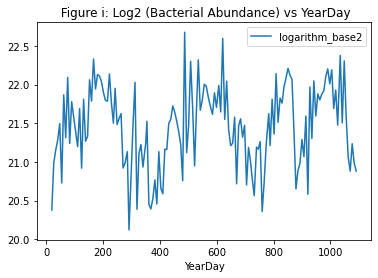

In [53]:
fig = plt.figure(figsize=(8, 8))

ax = df.plot.line(x='YearDay', y=[ 'logarithm_base2'])
ax.set_title(' Figure i: Log2 (Bacterial Abundance) vs YearDay')

[Text(0.5, 1.0, 'Figure ii: log2(Bacterial Abundance) vs Seasons')]

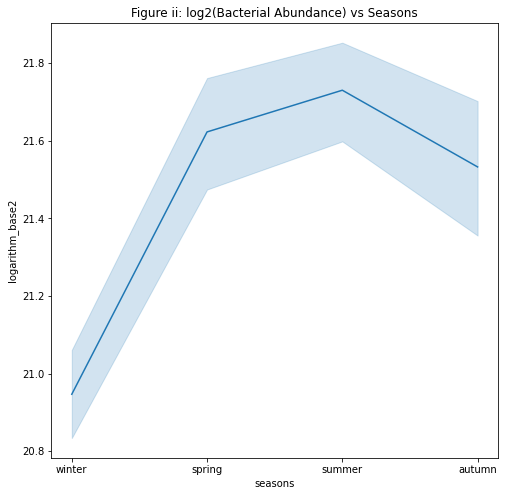

In [54]:
# let's do an preliminary plot of the logarithm of bacterial abundance based on season
fig = plt.figure(figsize=(8, 8))
sns.lineplot( x=df["seasons"],y=df["logarithm_base2"]).set(title='Figure ii: log2(Bacterial Abundance) vs Seasons')

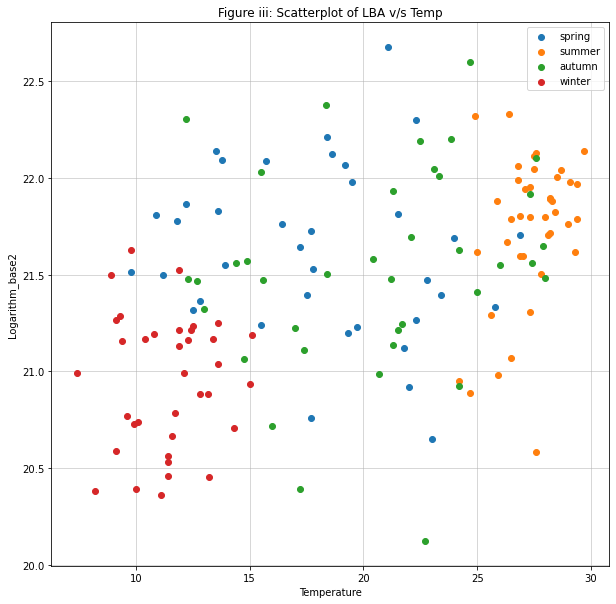

In [49]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
for name in ["spring", "summer", "autumn", "winter"]:
    ax.scatter(df.loc[df["seasons"] == name]["Temp"], 
               df.loc[df["seasons"] == name]["logarithm_base2"], 
               label = name, zorder=2)  # force data to be between grid lines via larger zorder
ax.set_xlabel(f"Temperature")
ax.set_ylabel(f"Logarithm_base2")
ax.set_title(f"Figure iii: Scatterplot of LBA v/s Temp")
ax.legend()
ax.grid(lw=0.5, zorder=0)    

From **figure i**, we can clear a very strong variation in the logarithm of bacterial abundance (LBA).

From **figure ii**, we observe a very strong seasonal variation in the LBA. With much lower values in the winter than compared to the spring and summer values. This followed by a drop moving into the autumn months.

From **figure iii** we can observe a sort of clustering between winter and summer LBA when plotted against temperature. This shows that the seasonality for the variation of LBA can be explained by environmental factors.

**Hypothesis**: Marine bacterial abundance is influenced by key environmental factors that account for the observed seasonal variation. 

# Analysis 

# Part I : Correlation and Regression


## Looking for correlations 

In the current dataset, we have 12 columns with different datasets. To get a better understanding of the environmental factors that play a role in the seasonal variation we check to see how the environmental factors correlate with each other, and then how they correlate with the LBA. 

**Note:** For this assignment we will be relying on Pearson correlation. 

  

Pearson Coeffecient for log2(Bacterial Abundance)
Temp                 0.460442
Salinity            -0.044344
Oxygen_Saturation   -0.010705
pH                   0.067734
DIC                 -0.101887
Chlorophyll          0.395401
NH4                 -0.036848
NO2.NO3              0.016414
PO4                 -0.007423
SiO4                 0.308424
logarithm_base2      1.000000
Name: logarithm_base2, dtype: float64


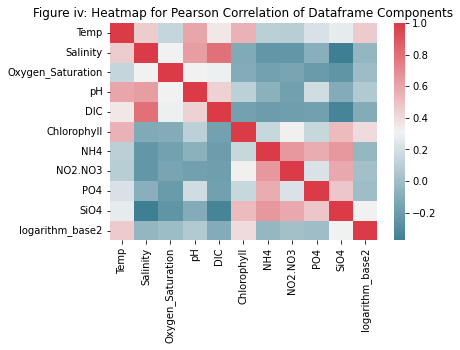

In [31]:
# creating a heatmap of correlation. 

dt = df[df.columns[2:]]

corr = dt.corr(method="pearson") 

sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values).set(title='Figure iv: Heatmap for Pearson Correlation of Dataframe Components')

# while heatmap focuses on all the components. Lets do numeric specifics for LBA 

print ("Pearson Coeffecient for log2(Bacterial Abundance)")
print("===============================")
print(dt.corr(method = "pearson").loc['logarithm_base2'])

Throughout the correlation heatmap, we can observe weak correlations between the components. For this analysis for any correlation coefficient value greater than 0.25 will be considered for further analysis. 

For the case of LBA, we can see a correlation with Temperature (0.46), Chlorophyll (0.39), and SiO4 (0.30).


figure v


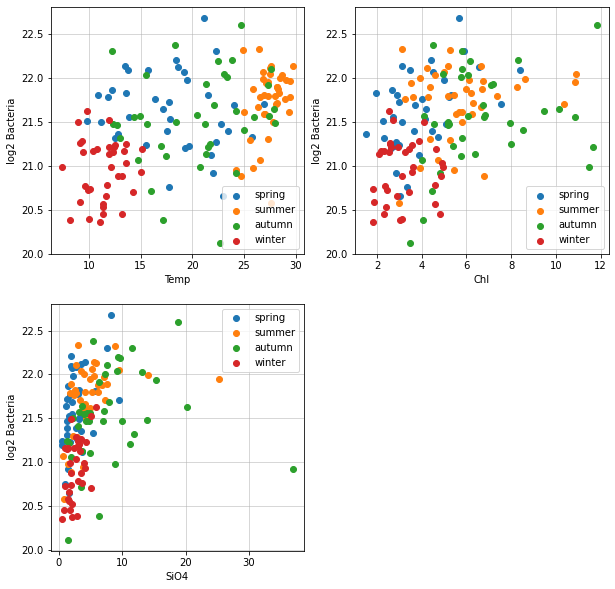

In [36]:
# Plotting out LBA with the correlated factors 

fig = plt.figure(figsize=(10, 10))

ax = plt.axes()
ax = plt.subplot(2,2,1)
for name in ["spring", "summer", "autumn", "winter"]:
    ax.scatter(df.loc[df["seasons"] == name]["Temp"], 
               df.loc[df["seasons"] == name]["logarithm_base2"], 
               label = name, zorder=2)  # force data to be between grid lines via larger zorder
ax.set_xlabel(f"Temp")
ax.set_ylabel(f"log2 Bacteria")
ax.legend()
ax.grid(lw=0.5, zorder=0)  


ax = plt.axes()
ax = plt.subplot(2,2,2)
for name in ["spring", "summer", "autumn", "winter"]:
    ax.scatter(df.loc[df["seasons"] == name]["Chlorophyll"], 
               df.loc[df["seasons"] == name]["logarithm_base2"], 
               label = name, zorder=2)  # force data to be between grid lines via larger zorder
ax.set_xlabel(f"Chl")
ax.set_ylabel(f"log2 Bacteria")
ax.legend()
ax.grid(lw=0.5, zorder=0) 


ax = plt.axes()
ax = plt.subplot(2,2,3)
for name in ["spring", "summer", "autumn", "winter"]:
    ax.scatter(df.loc[df["seasons"] == name]["SiO4"], 
               df.loc[df["seasons"] == name]["logarithm_base2"], 
               label = name, zorder=2)  # force data to be between grid lines via larger zorder
ax.set_xlabel(f"SiO4")
ax.set_ylabel(f"log2 Bacteria")
ax.legend()
ax.grid(lw=0.5, zorder=0)  

print("figure v")


In **figure v** we can observe some clustering clearly visible between the summer and winter LBA values when plotted against the correlated factors. 

A strong clustering is observed in Temperature and Chlorophyll graphs.

While a weaker effect is still visible in SiO4.



## Linear Regression 

Now that we know what factors correlate with the LBA, we can try and develop a linear regression model in order to predict the LBA. 

The 3 Factors that correlate with LBA were, SiO4, Chlorophyll, and Temperature.

Here we train 4 models to try and predict the LBA. 


In [38]:
# Training Models 

output_var = df['logarithm_base2'].values

N = len(output_var)

# Model 1. Temperature and Chlorophyll

input_var = df[['Temp', 'Chlorophyll']].values
model1 = linear_model.LinearRegression()
model1.fit(input_var, output_var)
num_coeff1 = len(model1.coef_)+1  
pred1 = model1.predict(input_var)
var1 = np.sum((pred1 - output_var) ** 2) / N

## Model 2 (Temperature and SiO4)
input_var = df[['Temp', 'SiO4']].values
model2 = linear_model.LinearRegression()
model2.fit(input_var, output_var)
num_coeff2 = len(model2.coef_)+1
pred2 = model2.predict(input_var)
var2 = np.sum((pred2 - output_var) ** 2) / N

## Model 3 (SiO4 and chlorophyll)
input_var = df[['SiO4', 'Chlorophyll']].values
model3 = linear_model.LinearRegression()
model3.fit(input_var, output_var)
num_coeff3 = len(model3.coef_)+1
pred3 = model3.predict(input_var)
var3 = np.sum((pred3 - output_var) ** 2) / N

## Model 4 (SiO4, Temperature, chlorophyll)
input_var = df[['Temp', 'SiO4', 'Chlorophyll']].values
model4 = linear_model.LinearRegression()
model4.fit(input_var, output_var)
num_coeff4 = len(model4.coef_)+1
pred4 = model4.predict(input_var)
var4 = np.sum((pred4 - output_var) ** 2) / N

### Akaike information criterion (AIC)  & Bayesian Information Criterion (BIC)

Now that we trained 4 models, we use the Akaike information criterion and BIC to assess which model is the most efficient in predicting the LBA. These models are better than gauging model accuracy than just looking at "mismatches and errors" since the two criteria penalize the use of additional variables/

BIC is harsher than the AIC on handing on penalties for using more variables to predict.

In [41]:
# creating the function for AIC
def calc_aic(k, variance, N):
    aic = 2 * k         + N * np.log(variance)
    return aic

# creating a function for BIC
def calc_bic(k, variance, N):
    bic = k * np.log(N) + N * np.log(variance)
    return bic

print("===============================")
print("AIC of models")
print("===============================")
print(f"model 1: AIC = {calc_aic(N, var1, num_coeff1):.6f}")
print(f"model 2: AIC = {calc_aic(N, var2, num_coeff2):.6f}")
print(f"model 3: AIC = {calc_aic(N, var3, num_coeff3):.6f}")
print(f"model 4: AIC = {calc_aic(N, var4, num_coeff4):.6f}")
print()

print("===============================")
print("BIC of models")
print("===============================")
print(f"model 1: BIC = {calc_bic(N, var1, num_coeff1):.6f}")
print(f"model 2: BIC = {calc_bic(N, var2, num_coeff2):.6f}")
print(f"model 3: BIC = {calc_bic(N, var3, num_coeff3):.6f}")
print(f"model 4: BIC = {calc_bic(N, var4, num_coeff4):.6f}")

AIC of models
model 1: AIC = 297.269295
model 2: AIC = 297.238179
model 3: AIC = 297.533372
model 4: AIC = 295.605683

BIC of models
model 1: BIC = 161.159751
model 2: BIC = 161.128635
model 3: BIC = 161.423827
model 4: BIC = 202.936131


From the prediction, we can see that the value for BIC is much higher for Model 4 than the remaining models. Despite it being the reverse for AIC. However, since the based on the large difference between the model BIC value, we reject Model 4. 

We can see that the remaining models have very similar AIC and BIC values, this is especially the case for model 1 and model 2. 

In [7]:
print("Pearson Coefficient: Temperature v/s Chlorophyll")
print(df.corr(method = "pearson").loc['Temp','Chlorophyll'])
print()
print()
print("Pearson Coefficient: Temperature v/s SiO4")
print(df.corr(method = "pearson").loc['Temp','SiO4'])

Pearson Coefficient: Temperature v/s Chlorophyll
0.5511472852252596


Pearson Coefficient: Temperature v/s SiO4
0.2694781588104955


However, an issue was observed in model 1 and model 2. We observe that some of the factors that are correlated with the LBA values are also correlated with each other. The presence of confounding variables would hinder the ability of the model to predict accurately. 

Hence for the first prediction model of the notebook, we use **Temperature and SiO4** to predict the LBA values.

In [102]:
lin_regr = linear_model.LinearRegression() 

input_var = df[['Temp', 'SiO4']].values
output_var = df['logarithm_base2'].values

lin_regr.fit(input_var, output_var)   


s, c = lin_regr.coef_, lin_regr.intercept_  # obtaining the slope and the coefficient 

print(f"suggested model is y = {c:.4f} + {s[0]:.4f} * x_1 + {s[1]:.4f} * x_2")
print(f"   r^2 value is {lin_regr.score(input_var, output_var):.4f}") 

ind = 0
pred_out = lin_regr.predict([[input_var[ind, 0], input_var[ind, 1]]])
print(f"input1 = {input_var[ind, 0]}, input2 = {input_var[ind, 1]}, actual value = {output_var[ind]}, pred value = {pred_out[0]}")

#####################################################################################################################################################################

# Modifying the table 
df_mod = df.copy(deep=True)


# make a prediction
N = input_var.shape[0]
pred_out = np.zeros(N)
for ind in range(N):
    pred_out[ind] = lin_regr.predict([[input_var[ind, 0], input_var[ind, 1]]])[0] # this is an array of predicted values

# now have an array of predicted values, put this into pandas to read
# syntax: df["whatever you want to call the column"] = data_array
df_mod["Pred_Log2_Bacteria Abundance"] = pred_out
df_mod["signed mismatches"] = pred_out - df_mod["logarithm_base2"] 
df_mod["squared mismatch"] = (pred_out - df_mod["logarithm_base2"]) ** 2

df_mod.sample(3)




suggested model is y = 20.7429 + 0.0317 * x_1 + 0.0223 * x_2
   r^2 value is 0.2487
input1 = 8.2, input2 = 2.09, actual value = 20.37788999802659, pred value = 21.04981315333376


,YearDay,Bacteria_abundance,Temp,Salinity,Oxygen_Saturation,pH,DIC,Chlorophyll,NH4,NO2.NO3,PO4,SiO4,seasons,logarithm_base2,Pred_Log2_Bacteria Abundance,signed mismatches,squared mismatch
80,599,3422727.273,28.1,33.0,90.4,7.97,2098.67,10.36,62.00,0.06,0.04,3.41,summer,21.706715,21.710933,0.004218,0.000018
19,166,5278378.378,26.4,36.0,100.7,8.06,2177.76,3.13,181.56,0.00,0.12,2.99,summer,22.331663,21.647608,-0.684056,0.467932
82,614,3283464.567,27.9,32.0,97.6,7.98,2043.97,10.14,65.50,0.00,0.03,3.65,autumn,21.646787,21.709934,0.063146,0.003987


Figure vi


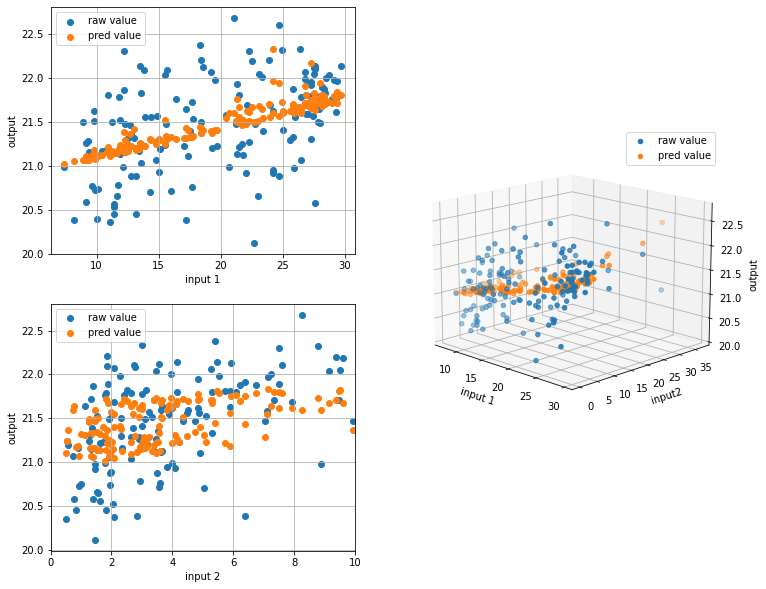

In [57]:
# lets plot out the predicted values in graphical terms 

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(2, 2, 1)
ax.scatter(input_var[:, 0], output_var, label="raw value")
ax.scatter(input_var[:, 0], df_mod["Pred_Log2_Bacteria Abundance"], label="pred value")
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"output"); ax.grid(); ax.legend();

ax = plt.subplot(2, 2, 3)
ax.scatter(input_var[:, 1], output_var, label="raw value")
ax.scatter(input_var[:, 1], df_mod["Pred_Log2_Bacteria Abundance"], label="pred value")
ax.set_xlabel(r"input 2"); ax.set_ylabel(r"output"); ax.grid(); ax.legend();plt.xlim([0, 10]);
# nvm if you change the scale its visible 

ax = plt.subplot2grid([2, 2], [0, 1], rowspan=2, colspan=1, projection="3d")
ax.scatter(input_var[:, 0], input_var[:, 1], output_var, label="raw value")
ax.scatter(input_var[:, 0], input_var[:, 1], df_mod["Pred_Log2_Bacteria Abundance"], label="pred value")
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"input2"); ax.set_zlabel(r"output"); ax.grid(); ax.legend(); 
ax.view_init(15, -45)

print("Figure vi")

# Analysis Part II


## Statistical Testing

In the previous section, we were able to observe that some environmental factors were correlated to the LBA values. Utilizing this method we were able to develop a model to try and predict the LBA.

Going back to **figure v** we can see that there is a clear seasonal observed in summer and winter seasons when the LBA is plotted against the temperature. 

In this section, we will look at trying to understand which components of the data set are statistically significant between seasons. 

Of course, the first component we look at is the LBA. 



0.42408365805823645


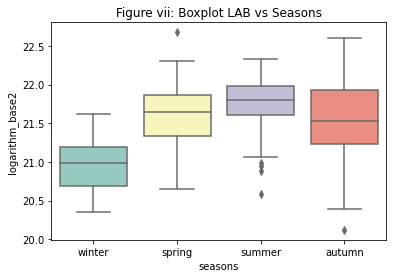

In [63]:
# generating a box plot 
ax = sns.boxplot(x="seasons", y="logarithm_base2",
                 data=df, palette="Set3").set(title='Figure vii: Boxplot LAB vs Seasons')

Just by looking at **figure vii** we can see a very clear distinction between the summer and winter means of LBA. However, it is a bit more challenging to decipher the difference between the other seasons. 

To confirm the statistical significance of the impact of seasonal variation on the LBA value, we first run an F test on the data set. 

### F Test 

In [70]:
alpha = 0.001 
var = "logarithm_base2"
f_val, p_val = stats.f_oneway(summer_data[var], winter_data[var], fall_data[var], spring_data[var])

print("=================")
print("F-test evaluation")
print("=================")
print(f"Null Hypothesis: All means are the same, across seasons, threshold value of {alpha:.3f}")
print(f"(Alternate Hypothesis: All means are not the same)")
print(" ")
print(f"one-sided f-value from data set is {f_val}, p-value is {p_val}")
print()
if p_val < alpha:
    print(f"  p-value smaller than threshold, REJECT null hypothesis")
    print(" ")
    print(f"    *** at least one pair with different mean, likely at the alpha = {alpha} significance ***")
    print(" ")
else:
    print(f"  p-value not smaller than threshold, FAIL TO REJECT the null hypothesis")
    print(" ")
    print(f"    *** cannot conclude means are different ***")

F-test evaluation
Null Hypothesis: All means are the same, across seasons, threshold value of 0.001
(Alternate Hypothesis: All means are not the same)
 
one-sided f-value from data set is 24.16669050037647, p-value is 9.024583939659405e-13

  p-value smaller than threshold, REJECT null hypothesis
 
    *** at least one pair with different mean, likely at the alpha = 0.001 significance ***
 


From the one way F test, we can see that not all means are equal. However, we still cannot tell which seasons are exactly statistically different. To solve this issue, we will use Tukey's honest significance test (Tukey HSD). 

In [74]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['logarithm_base2'],
                          groups=df['seasons'],
                          alpha=0.001)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.00 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
autumn spring   0.0902 0.7793 -0.2946  0.4749  False
autumn summer   0.1977 0.1866 -0.1797  0.5751  False
autumn winter  -0.5857  0.001 -0.9732 -0.1983   True
spring summer   0.1075 0.6749 -0.2725  0.4875  False
spring winter  -0.6759  0.001 -1.0659 -0.2859   True
summer winter  -0.7834  0.001 -1.1661 -0.4007   True
----------------------------------------------------


From the Tukey HSD test, we can see that there are 3 pairs that are statistically different. The three pairs are 
* Autumn | Winter 
* Spring | Winter 
* Summer | Winter 

This is very interesting to note, as it shows that the LBA diminishes drastically in the Winter months. 

In the remainder of this notebook, we will look more in-depth at the Summer-Winter variation, and look into the environmental factors that cause it. 

### Summer ~ Winter Variation 

We have established that there is a clear variation in the means of summer and winter LBA. We will now look at what other environmental factors also vary significantly between the summer and winter months. The idea here is that the factors that change significantly between the two seasons must be the ones that cause the variation in the LBA. 

For trying to understand the variation in the environmental factors we will be using the students t-test 

In [2]:
alpha = 0.001 # alpha value taken from Charmaine's paper 

print("Null Hypothesis for all tests is that the mean value of the 'factor' is equal")

# two sample independent t test 
# Temperature
print("================================")
print("t Test for the Temperature value") 
t_val, p_val = stats.ttest_ind(summer_data["Temp"], winter_data["Temp"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for Temperature is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")

# Salinity
print("================================")
print("t Test for the Salinity value") 
t_val, p_val = stats.ttest_ind(summer_data["Salinity"], winter_data["Salinity"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for Salinity is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")
    


# O2
print("================================")
print("t Test for the O2 value") 
t_val, p_val = stats.ttest_ind(summer_data["Oxygen_Saturation"], winter_data["Oxygen_Saturation"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for O2 is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")
    
# pH
print("================================")
print("t Test for the pH value") 
t_val, p_val = stats.ttest_ind(summer_data["pH"], winter_data["pH"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for pH is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")
    
    
    
# DIC
print("================================")
print("t Test for the DIC value") 
t_val, p_val = stats.ttest_ind(summer_data["DIC"], winter_data["DIC"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for DIC is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")
    
    
# Chlorophyll
print("================================")
print("t Test for the Chlorophyll value") 
t_val, p_val = stats.ttest_ind(summer_data["Chlorophyll"], winter_data["Chlorophyll"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for Chlorophyll is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")
    
 

##
#NH4
print("================================")
print("t Test for the NH4 value") 
t_val, p_val = stats.ttest_ind(summer_data["NH4"], winter_data["NH4"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for NH4 is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")

    
# NO2.NO3
print("================================")
print("t Test for the NO2.NO3 value") 
t_val, p_val = stats.ttest_ind(summer_data["NO2.NO3"], winter_data["NO2.NO3"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for NO2.NO3 is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")

    

# PO4
print("================================")
print("t Test for the PO4 value") 
t_val, p_val = stats.ttest_ind(summer_data["PO4"], winter_data["PO4"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for PO4 is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")
    

# SiO4
print("================================")
print("t Test for the SiO4 value") 
t_val, p_val = stats.ttest_ind(summer_data["SiO4"], winter_data["SiO4"])
if (p_val < alpha):
    print(f"Temp two-sided p-value from data sample for SiO4 is {p_val}")
else: 
    print("Fails the test. Cannot reject the hypothesis")
    


Null Hypothesis for all tests is that the mean value of the 'factor' is equal
t Test for the Temperature value


NameError: name 'stats' is not defined

To summarise, the values that did vary significantly between summer and winter were 
* Temperature 
* Salinity 
* pH 
* Chlorophyll 
* DIC 

### Principal Component Analysis 

In this analysis section, we will try and look a the components that played a role in the seasonal variation in the LBA values.

The first PCA will look at the values that varied significantly based on the student t-test. 



In [ ]:
#loading PCA packages 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

,PC1,PC2,seasons
130,-1.440634,0.272913,summer
108,3.523144,-0.022535,spring
31,0.218319,2.257194,autumn


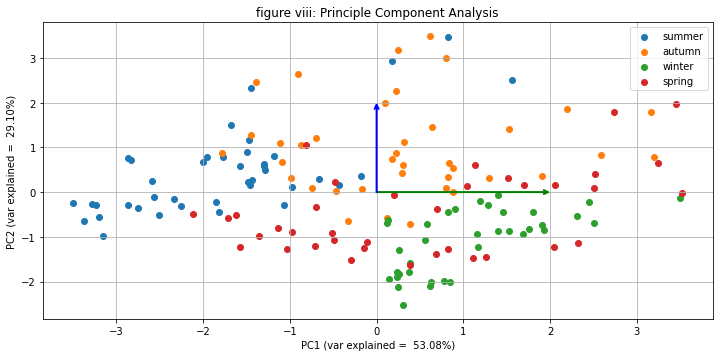

In [99]:
input_var = df[['Temp', 'Salinity', 'Chlorophyll', 'pH', 'DIC']].values


# scale the data
scaler = StandardScaler()
input_scaled = scaler.fit_transform(input_var) 


pca = PCA(n_components=2)   # define a PCA object with two PCAs (can choose more for larger data)
pca_comp = pca.fit_transform(input_scaled)

# generatre a data frame with PC1 and PC2 values
pca_df = pd.DataFrame(data = pca_comp, columns = ['PC1', 'PC2'])
pca_df["seasons"] = df.loc[:,['seasons']].values  
       


fig = plt.figure(figsize=(12,12))
ax = plt.subplot(2, 1, 2)
for name in ["summer", "autumn", "winter", "spring"]:
    ax.scatter(pca_df.loc[df["seasons"] == name]["PC1"], pca_df.loc[df["seasons"] == name]["PC2"], label = name)
ax.set_xlabel(f"PC1 (var explained = {pca.explained_variance_ratio_[0] * 100 : .2f}%)");
ax.set_ylabel(f"PC2 (var explained = {pca.explained_variance_ratio_[1] * 100 : .2f}%)");
ax.set_title("figure viii: Principle Component Analysis")
ax.grid();
ax.legend();
ax.annotate("", [2, 0], [0, 0],
            arrowprops=dict(color="green", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))
ax.annotate("", [0, 2], [0, 0],
            arrowprops=dict(color="blue", arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0))



pca_df.sample(3)  

In the above PCA, we can clearly see two clusters being formed between the Summer and Winter values. However, we cannot make any such claim for the autumn and spring values which do not seem to cluster.

### Linear Regression using PC1 and PC2
In this final analysis section, we will try to develop another linear regression model using the PC data obtained. In this piece of code, we will go through with the AIC/BIC check as well as data prediction. 


In [104]:
lin_regr = linear_model.LinearRegression() 

input_var1 = pca_df[['PC1', 'PC2']].values # using PC1 and PC2 
output_var = df['logarithm_base2'].values # from original dataset 

lin_regr.fit(input_var1, output_var)   


s, c = lin_regr.coef_, lin_regr.intercept_  # obtaining the slope and the coefficient 

print(f"suggested model is y = {c:.4f} + {s[0]:.4f} * x_1 + {s[1]:.4f} * x_2")
print(f"   r^2 value is {lin_regr.score(input_var, output_var):.4f}") 

ind = 0
pred_out = lin_regr.predict([[input_var1[ind, 0], input_var1[ind, 1]]])
print(f"input1 = {input_var1[ind, 0]}, input2 = {input_var1[ind, 1]}, actual value = {output_var[ind]}, pred value = {pred_out[0]}")

#####################################################################################################################################################################

# Modifying the table 
df_mod = df.copy(deep=True)


# make a prediction
N = input_var1.shape[0]
pred_out = np.zeros(N)
for ind in range(N):
    pred_out[ind] = lin_regr.predict([[input_var1[ind, 0], input_var1[ind, 1]]])[0] # this is an array of predicted values

# now have an array of predicted values, put this into pandas to read
# syntax: df["whatever you want to call the column"] = data_array
df_mod["Pred_Log2_Bacteria Abundance"] = pred_out
df_mod["signed mismatches"] = pred_out - df_mod["logarithm_base2"] 
df_mod["squared mismatch"] = (pred_out - df_mod["logarithm_base2"]) ** 2

df_mod.sample(3)




suggested model is y = 21.4672 + -0.0425 * x_1 + 0.2024 * x_2
   r^2 value is -2.4737
input1 = 1.6848549915273294, input2 = -0.9327021867547058, actual value = 20.37788999802659, pred value = 21.206799253208693


,YearDay,Bacteria_abundance,Temp,Salinity,Oxygen_Saturation,pH,DIC,Chlorophyll,NH4,NO2.NO3,PO4,SiO4,seasons,logarithm_base2,Pred_Log2_Bacteria Abundance,signed mismatches,squared mismatch
37,291,1140410.959,22.7,32.00,93.80,8.04,2031.30,3.46,455.1,0.05,0.23,1.45,autumn,20.121122,21.519421,1.398298,1.955238
149,1084,2082000.000,12.1,32.39,91.65,7.92,2047.47,4.95,76.5,0.00,0.05,3.99,winter,20.989539,21.353077,0.363539,0.132160
126,921,1569668.246,27.6,35.38,100.90,8.00,2078.23,2.98,7.5,0.00,0.01,0.78,summer,20.582028,21.454221,0.872192,0.760719


In [105]:
# Checking AIC and BIC 
# Re training the model from above
input_var1 = pca_df[['PC1', 'PC2']].values
model = linear_model.LinearRegression()
model.fit(input_var, output_var)
num_coeff = len(model1.coef_)+1  
pred = model.predict(input_var)
var = np.sum((pred1 - output_var) ** 2) / N

# AIC 
print("AIC of models")
print("===============================")
print(f" AIC = {calc_aic(N, var, num_coeff):.6f}")

print("BIC of models")
print("===============================")
print(f"BIC = {calc_bic(N, var, num_coeff1):.6f}")


AIC of models
 AIC = 297.285756
BIC of models
BIC = 161.176211


### Plotting out the PCA based Linear Regression Model



Figure ix


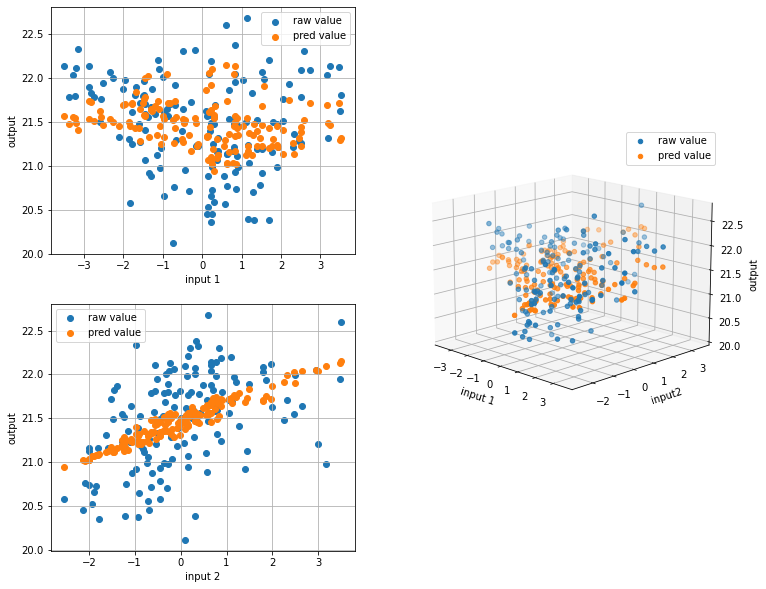

In [107]:
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(2, 2, 1)
ax.scatter(input_var1[:, 0], output_var, label="raw value")
ax.scatter(input_var1[:, 0], df_mod["Pred_Log2_Bacteria Abundance"], label="pred value")
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"output"); ax.grid(); ax.legend();

ax = plt.subplot(2, 2, 3)
ax.scatter(input_var1[:, 1], output_var, label="raw value")
ax.scatter(input_var1[:, 1], df_mod["Pred_Log2_Bacteria Abundance"], label="pred value")
ax.set_xlabel(r"input 2"); ax.set_ylabel(r"output"); ax.grid(); ax.legend();
# nvm if you change the scale its visible 

ax = plt.subplot2grid([2, 2], [0, 1], rowspan=2, colspan=1, projection="3d")
ax.scatter(input_var1[:, 0], input_var1[:, 1], output_var, label="raw value")
ax.scatter(input_var1[:, 0], input_var1[:, 1], df_mod["Pred_Log2_Bacteria Abundance"], label="pred value")
ax.set_xlabel(r"input 1"); ax.set_ylabel(r"input2"); ax.set_zlabel(r"output"); ax.grid(); ax.legend(); 
ax.view_init(15, -45)

print("Figure ix")

# Discussion 

### Seasonal Variation 

Clearly from the analysis, we can see that there is a seasonal variation in the LBA values. Distinct clustering effects could be seen among the winter and summer bacterial populations. We observed a significant variation in the bacterial abundance in the winter populations against the other seasons (p-value < 0.001). Meanwhile, the remaining seasons did not show any statistically significant change in LBA. Despite the statistical significance of LBA values of winter against all seasons, for this study, we chose to focus on the Summer ~ Winter variation, due to the observed seasonal clustering (figure viii).

This raises an interesting question regarding the reasons for the significant decline in the Bacterial population in the winter season. To further understand the possible causes, the environmental factors between the summer and winter months were statistically tested using the student's t-test. 5 key environmental factors varied significantly (p<0.001) between the two seasons. Namely: Temperature, Salinity, DIC, pH, and Chlorophyll. 

The Temperature and Chlorophyll values also showed a correlation with the LBA values, 0.46 and 0.39 respectively. This indicated that the two environmental roles could play a strong role in maintaining the marine bacterial abundance. 

The temperature has been shown to be a primary driver of bacterial composition in other studies [2]. Ambient temperatures are crucial for the appropriate cycling of nutrients and growth in bacteria. Phytoplankton in the marine environment extract silica from the water for their building their cell walls [4], which could account for the higher SiO4 values in the summer values. 

Heterotrophic bacteria are the main consumers of the Dissolved Organic Matter produced by phytoplankton [3] The increased temperature could serve as a proxy for increased light availability. The higher availability of light would allow for more photosynthesis in marine phytoplankton. Further adding to this, we observe an increase of Chlorophyll values in the summer months can act as a proxy for phytoplankton populations.

Phytoplankton is a keystone species in the marine environment. As this phytoplankton produces more DOM, it would allow for more available food for marine bacteria. 


### Predicting log2(Bacterial Abundance) 

A large focus of this notebook is in trying to develop a linear model trying the predict bacterial abundance in marine environments across seasons. We developed two main models, the first being based on Pearson correlation values, and the second based on statistical testing and principal component analysis.

**Correlation Model **

In this model, SiO4 and Temperature were used as the input values. 

An $r^2$ value of 0.2487. 

AIC = 297.23 and BIC of 161.12

**PCA Based Model** 

In this model, PC1 and PC2 values were used for developing a linear model. The input used for the mode were Temperature, Chlorophyll, pH, Salinity, and DIC. 

An $r^2$ value of 0.2366

AIC = 297.28 and BIC = 161.17


Both models seemed to have similar outputs, but the correlation model seemed to edge out the PCA model by a fraction. However, an issue observed in both models was the presence of correlated variables. 

Some key factors that were correlated to the LBA values, were also strongly correlated to each other. Calculating  Pearson's coefficient for some factors 

    * Temperature and SiO4 = 0.296
    * Temperature and Chlorophyll = 0.55 

The presence of factors that are correlated could hinder the prediction power of the model.

# Conclusion

Both models developed seemed to be equally accurate in predicting the marine bacterial abundance. However, it is crucial to account for "correlated" variables. Factors like Chlorophyll and Temperature are not just correlated with LBA but also with each other, this could present some issues for the developed model. A distinct seasonal clustering pattern was observed for LBA, for the summer and winter seasons. No such pattern could be detected for Autumn and Spring.  

# Bibliography 

1. About marine microbes. Marine. (2021, October 12). Retrieved March 25, 2022, from https://serc.carleton.edu/microbelife/marine/about.html#:~:text=Marine%20microbes%20play%20many%20important,of%20medicines%20and%20natural%20products. 

2. Ward, Christopher S, Cheuk-Man Yung, Katherine M Davis, Sara K Blinebry, Tiffany C Williams, Zackary I Johnson, and Dana E Hunt. ‘Annual Community Patterns Are Driven by Seasonal Switching between Closely Related Marine Bacteria’. The ISME Journal 11, no. 6 (June 2017): 1412–22. https://doi.org/10.1038/ismej.2017.4.


3. Camarena-Gómez, M. T., Ruiz-González, C., Piiparinen, J., Lipsewers, T., Sobrino, C., Logares, R., & Spilling, K. (2021). Bacterioplankton dynamics driven by interannual and spatial variation in diatom and dinoflagellate spring bloom communities in the Baltic Sea. Limnology and Oceanography, 66(1), 255–271. https://doi.org/10.1002/lno.11601


4. Physical factors that control microbial growth. (n.d.). Retrieved March 25, 2022, from https://www2.hawaii.edu/~johnb/micro/m140/syllabus/week/handouts/m140.9.1.html 

5. Jonas, Robert B. ‘Bacteria, Dissolved Organics and Oxygen Consumption in Salinity Stratified Chesapeake Bay, an Anoxia Paradigm’. American Zoologist 37, no. 6 (December 1997): 612–20. https://doi.org/10.1093/icb/37.6.612.

6. Robinson, Carol. ‘Microbial Respiration, the Engine of Ocean Deoxygenation’. Frontiers in Marine Science 5 (17 January 2019): 533. https://doi.org/10.3389/fmars.2018.00533.
